# Análisis OMPA con Simulaciones Monte Carlo
### Trabajo de Fin de Grado - Aitana Tomás San Martín
#### Tutor: Leopoldo Pena 
#### Ciéncias del Mar UB                    


Este cuaderno implementa una herramienta computacional que combina el método de análisis multiparamétrico óptimo (OMPA) con simulaciones de Monte Carlo, con el fin de mejorar la estimación de mezclas de masas de agua y cuantificar la incertidumbre asociada.

Este enfoque se ha aplicado a los datos de la campaña oceanográfica **TRANSMOW**, centrada en el margen ibérico atlántico. La implementación del Análisis Multiparámétrico Óptimo (OMPA) utilizada en este trabajo se basa en los principios y metodologías detalladas en el libro *Modeling Methods for Marine Science* de Glover, D. M., Jenkins, W. J., & Doney, S. C. (2011), Cambridge University Press (https://doi.org/10.1017/CBO9780511975721). Esta obra proporciona el marco teórico detallado y las herramientas conceptuales fundamentales para la correcta aplicación del OMPA en el contexto de las ciencias marinas.

.

-------------------------------------
**Resumen del proceso:**
1. Configuración del entorno
2. Importación y preparación de datos
2. Generación aleatoria de endmembers y vectores de error
3. Estandarización y ponderación
4. Resolución del sistema OMPA
5. Simulación Monte Carlo
7. Análisis estadístico y visualización de resultados


## 1. Configuración del entorno

Importamos las bibliotecas necesarias para análisis numérico, manipulación de datos y visualización. 

### Librerías nacesarias y modulos
A continuación, se describen las librerías utilizadas:

- **NumPy (np)**: Esta librería es esencial para la realización de operaciones matemáticas y algebraicas, como la manipulación de arrays y matrices. En el desarrollo del código, NumPy se utiliza principalmente para generar números aleatorios con distribuciones normales (función np.random.normal), calcular medias, desviaciones estándar y realizar operaciones sobre matrices de datos (como la creación de las matrices de endmembers aleatorios). Además, se utiliza para cálculos de ponderación y estandarización de matrices, que son pasos clave en la implementación del Análisis Multiparamétrico Óptimo (OMPA) y la técnica de Monte Carlo.

- **Pandas (pd)**: Pandas es una librería crucial para la manipulación y análisis de datos estructurados, especialmente cuando los datos están organizados en tablas (DataFrames). A lo largo del proyecto, se hace uso de Pandas para leer y escribir archivos CSV, como en la carga de los datos oceanográficos y los resultados de las simulaciones. Además, permite realizar manipulaciones de datos como la estandarización de matrices y la concatenación de múltiples DataFrames (por ejemplo, cuando se generan resultados de simulaciones de Monte Carlo). En el contexto de la modelización de las mezclas de masas de agua, Pandas también se utiliza para gestionar las matrices de diseño y las matrices de datos experimentales.

- **Matplotlib (plt)**: Matplotlib es la librería utilizada para la visualización de datos. En este proyecto, se utiliza principalmente para la creación de histogramas y gráficos que muestran la distribución de las masas de agua en las distintas estaciones de muestreo. A través de la función plt.hist, se generan histogramas que permiten visualizar la distribución de los resultados obtenidos a partir de las simulaciones, lo que facilita la interpretación de los datos y la comprensión de la variabilidad en los resultados.

- **SciPy (scipy y scipy.optimize)**: SciPy es una librería de Python que extiende las funcionalidades de NumPy, especialmente en el ámbito de la optimización y las funciones estadísticas. En este proyecto, se utiliza específicamente la sublibrería scipy.optimize para resolver problemas de optimización mediante el método de mínimos cuadrados no negativos (función scipy.optimize.nnls). Este algoritmo es central en la implementación del OMPA, ya que permite encontrar la combinación óptima de masas de agua que mejor se ajusta a las observaciones experimentales, minimizando los residuos y calculando el error relativo de las soluciones obtenidas.

- **Seaborn (sns)**: Seaborn es una librería de visualización de datos basada en Matplotlib que proporciona una interfaz de alto nivel para crear gráficos estadísticos. En este proyecto, Seaborn se utiliza para generar histogramas con distribución de densidad de Kernel (KDE) de las masas de agua simuladas. Esto facilita la interpretación visual de la distribución de las concentraciones de los trazadores geoquímicos en las muestras, permitiendo observar las características estadísticas de las diferentes masas de agua y evaluar la variabilidad asociada a las simulaciones de Monte Carlo.

- **Scikit-learn (preprocessing)**: La librería Scikit-learn incluye herramientas útiles para la estandarización y escalado de datos. En el contexto de este proyecto, la función preprocessing.scale de Scikit-learn se utiliza para estandarizar las matrices de diseño y las matrices de datos. Este proceso de estandarización es esencial para garantizar que todas las variables se encuentren en la misma escala y puedan ser comparadas de manera adecuada, especialmente cuando se aplican técnicas como el OMPA, que requiere que los datos estén en una escala común.

En conjunto, estas librerías permiten desarrollar y optimizar el análisis de mezclas de masas de agua en función de múltiples trazadores, generando simulaciones robustas y visualizaciones detalladas.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, preprocessing

# 2. Importar datos
El procesamiento de datos se inicia con la importación de tres conjuntos fundamentales: una matriz de valores medios de trazadores (en este caso salinidad, temperatura potencial, oxígeno y spiciness) para cada masa de agua identificada (en este caso ENACW16, ENACW12, MW, LSW, NEADW), una matriz de desviaciones estándar asociadas a estos trazadores, y el conjunto completo de datos observacionales de la campaña, que incluye valores de trazadores con su correspondiente información espacial y temporal.

## 2.1 Importar nuestras muestras

In [5]:
#IMPORTAR DATOS DE LAS MUESTRAS EN FORMATO CSV, EN ESTE CASO DE LA CAMPAÑA TRANSMOW
data_t = pd.read_csv('C:/Users/Aitana/Documents/Python Scripts/OMPA FINAL/OMPA_ODV/data_ompa')

In [6]:
# Seleccior las columnas necesarias de los datos de nuestras muestras
data = data_t[['Salinity', 'Temperature', 'Oxygen', 'spice0']].copy()

# Renombrar las columnas
data.columns = ['Salinity', 'Potential Temperature', 'Oxygen', 'spiciness']

# Mostrar
print(data)

     Salinity  Potential Temperature  Oxygen  spiciness
0     36.5802                  12.96   185.7   2.994490
1     36.5832                  12.98   185.9   3.000902
2     36.5905                  13.05   187.0   3.021101
3     36.5933                  13.06   187.2   3.025253
4     36.5726                  13.08   188.1   3.014300
..        ...                    ...     ...        ...
932   36.0746                  15.45   253.1   3.141043
933   36.0810                  15.45   253.5   3.145727
934   36.0778                  15.45   253.4   3.143330
935   35.9960                  17.00   246.4   3.447084
936   35.9962                  17.00   246.4   3.447191

[937 rows x 4 columns]


## 2.2 Visualización de nuestras muestras
Para la identificación de los endmembers, es recomendable analizar todos los datos disponibles de las estaciones de muestreo y se representaron en un diagrama de temperatura frente a salinidad (T–S), donde se superponen las principales masas de agua potencialmente presentes en la región de estudio.  En nuestro caso, se colocan las principales masas de agua características del océano Atlántico descritas por García-Ibáñez et al., 2018, ya que nuestra zona de estudio es el margen Ibérico Atlántico. 

La elección de las masas de agua se basa en la coherencia entre sus propiedades físico-químicas y la forma observada en la nube de puntos. Los cambios abruptos en la trayectoria T-S de las muestras indican transiciones claras entre diferentes masas de agua. En general, los puntos más superficiales muestran una mayor dispersión. Como se puede observar en la figura, las masas de agua superficiales presentan una mayor dispersión en el espacio T-S, lo que refleja un rango de variabilidad más amplio en sus propiedades. Esta variabilidad es esperable dado su contacto más directo con la atmósfera y los procesos estacionales. Por el contrario, las masas de agua profundas muestran una distribución más compacta, lo que indica una menor variabilidad en sus características. Esta diferencia en la amplitud de variabilidad entre masas superficiales y profundas es especialmente relevante para nuestras simulaciones, ya que influye directamente en la representación de las incertidumbres en el modelo de mezcla. Por eso es importante señalar que en nuestro caso las masas NEADWu y LSW están muy próximas entre sí en el diagrama T-Sí, lo que podría dificultar su diferenciación precisa mediante el OMPA.


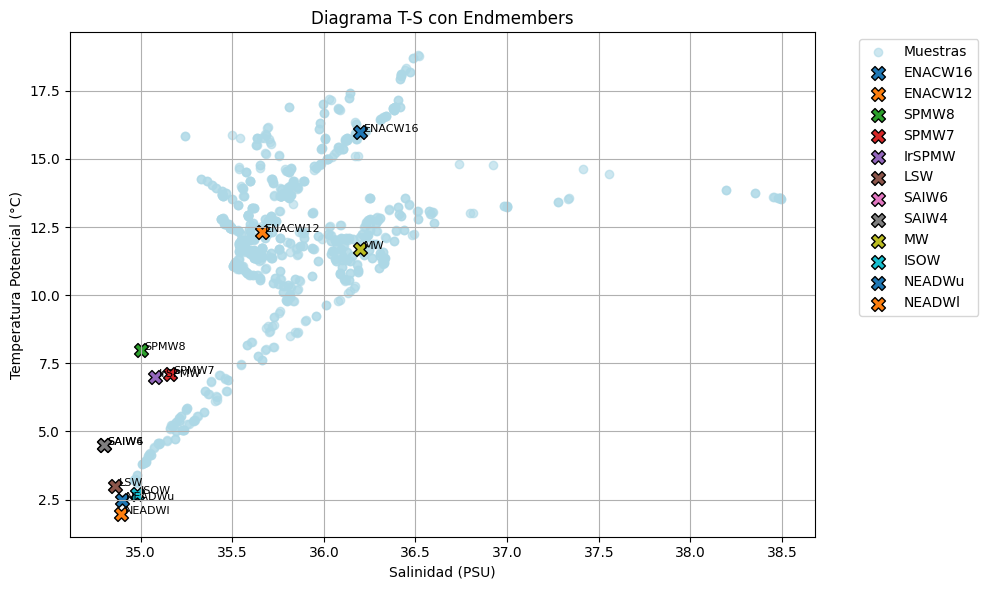

In [11]:
# VISUALIZACION DE LOS DATOS A TRAVÉS DE UN DIAGRAMA T-S
# Definir los endmembers potenciales participantes en nuestra mezcla
endmembers = {
    "ENACW16": {"Theta": 16.0, "S": 36.20},
    "ENACW12": {"Theta": 12.3, "S": 35.66},
    "SPMW8": {"Theta": 8.0, "S": 35.00},
    "SPMW7": {"Theta": 7.1, "S": 35.16},
    "IrSPMW": {"Theta": 7.0, "S": 35.08},
    "LSW": {"Theta": 3.0, "S": 34.86},
    "SAIW6": {"Theta": 4.5, "S": 34.80},
    "SAIW4": {"Theta": 4.5, "S": 34.80},
    "MW": {"Theta": 11.7, "S": 36.2},
    "ISOW": {"Theta": 2.7, "S": 34.98},
    "NEADWu": {"Theta": 2.5, "S": 34.90},
    "NEADWl": {"Theta": 1.98, "S": 34.895},
}

# Crear el diagrama T-S
plt.figure(figsize=(10, 6))

# Plot de las muestras
plt.scatter(data['Salinity'], data['Potential Temperature'], c='lightblue', label='Muestras', alpha=0.6)

# Agregar los endmembers
for name, props in endmembers.items():
    plt.scatter(props['S'], props['Theta'], label=name, edgecolor='black', s=100, marker='X')
    plt.text(props['S'] + 0.02, props['Theta'], name, fontsize=8)

# Ajustar el plot
plt.gca()
plt.xlabel('Salinidad (PSU)')
plt.ylabel('Temperatura Potencial (°C)')
plt.title('Diagrama T-S con Endmembers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.savefig('diagrama_ts.png', dpi=300)

# Mostrar
plt.show()

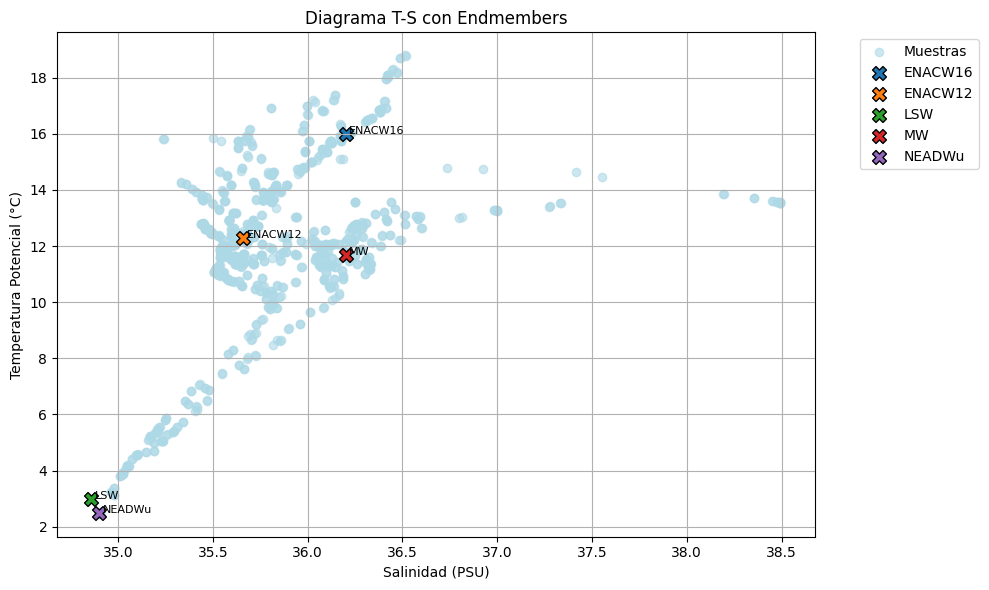

In [12]:
# Diagrama T-S de los endmembers que más se ajustan a la forma de tus muestras
endmembers = {
    "ENACW16": {"Theta": 16.0, "S": 36.20},
    "ENACW12": {"Theta": 12.3, "S": 35.66},
    "LSW": {"Theta": 3.0, "S": 34.86},
    "MW": {"Theta": 11.7, "S": 36.2},
    "NEADWu": {"Theta": 2.5, "S": 34.90},
}

# Crear el diagrama T-S
plt.figure(figsize=(10, 6))

# Plot de las muestras
plt.scatter(data['Salinity'], data['Potential Temperature'], c='lightblue', label='Muestras', alpha=0.6)

# Agregar los endmembers
for name, props in endmembers.items():
    plt.scatter(props['S'], props['Theta'], label=name, edgecolor='black', s=100, marker='X')
    plt.text(props['S'] + 0.02, props['Theta'], name, fontsize=8)

# Ajustar el plot
plt.gca()
plt.xlabel('Salinidad (PSU)')
plt.ylabel('Temperatura Potencial (°C)')
plt.title('Diagrama T-S con Endmembers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.savefig('diagrama_ts_5.png', dpi=300)

# Mostrar
plt.show()

## 2.3 Definir matriz de endmembers
Una vez escogidos los endmembers que mejor se ajusten a la forma de tus datos puedes importar tu matriz de endmembers desde un csv como a continuación. 

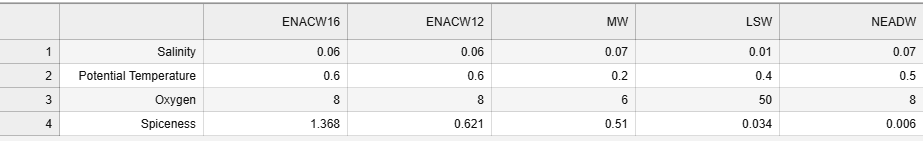

O puedes crear tu matriz manualmente como en el diagrama T-S anterior. 
Es necesario añadir también una matriz de la desviación estandard de cada endmember para cada trazador.

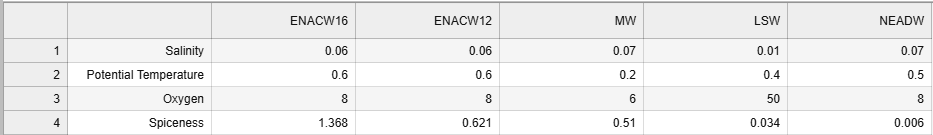

In [15]:
#IMPORAR MATRIZ DE ENDMEMBERS CSV
design_M = pd.read_csv('C:/Users/Aitana/Documents/Python Scripts/OMPA FINAL/OMPA_ODV/Matriz_media_end.csv')
design_M_desvest = pd.read_csv('C:/Users/Aitana/Documents/Python Scripts/OMPA FINAL/OMPA_ODV/Matriz_std_end.csv')

In [17]:
design_M

,Unnamed: 0,ENACW16,ENACW12,MW,LSW,NEADW
0,Salinity,36.20,35.66,36.50,34.86,34.94
1,Potential Temperature,16.00,12.30,11.70,3.40,2.50
2,Oxygen,246.00,251.00,190.00,307.00,274.00
3,Spiceness,3.42,2.07,2.55,0.34,0.12


In [19]:
design_M_desvest

,Unnamed: 0,ENACW16,ENACW12,MW,LSW,NEADW
0,Salinity,0.060,0.060,0.07,0.010,0.070
1,Potential Temperature,0.600,0.600,0.20,0.400,0.500
2,Oxygen,8.000,8.000,6.00,50.000,8.000
3,Spiceness,1.368,0.621,0.51,0.034,0.006


In [21]:
data_t

,Codi,Date,Longitude,Latitude,Pressure,Temperature,Salinity,Oxygen,DEPTH,Bottom Depth,SA,CT,spice0
0,ST11_1,May 03 2021,-7.7467,36.3431,0,12.96,36.5802,185.7,1025.0,1035.0,36.753400,12.913437,2.994490
1,ST11_2,May 03 2021,-7.7467,36.3431,1,12.98,36.5832,185.9,1024.0,1035.0,36.756414,12.933190,3.000902
2,ST11_3,May 03 2021,-7.7467,36.3431,2,13.05,36.5905,187.0,920.0,1035.0,36.763748,13.002739,3.021101
3,ST11_4,May 03 2021,-7.7467,36.3431,3,13.06,36.5933,187.2,920.0,1035.0,36.766560,13.012516,3.025253
4,ST11_5,May 03 2021,-7.7467,36.3431,4,13.08,36.5726,188.1,849.0,1035.0,36.745762,13.032807,3.014300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,ST28_bis_20,May 07 2021,-10.3468,39.5945,961,15.45,36.0746,253.1,65.0,4417.0,36.246897,15.259048,3.141043
933,ST28_bis_21,May 07 2021,-10.3468,39.5945,962,15.45,36.0810,253.5,65.0,4417.0,36.253329,15.258714,3.145727
934,ST28_bis_22,May 07 2021,-10.3468,39.5945,963,15.45,36.0778,253.4,65.0,4417.0,36.250115,15.258636,3.143330
935,ST28_bis_23,May 07 2021,-10.3468,39.5945,964,17.00,35.9960,246.4,20.0,4417.0,36.167926,16.799607,3.447084


In [23]:
data

,Salinity,Potential Temperature,Oxygen,spiciness
0,36.5802,12.96,185.7,2.994490
1,36.5832,12.98,185.9,3.000902
2,36.5905,13.05,187.0,3.021101
3,36.5933,13.06,187.2,3.025253
4,36.5726,13.08,188.1,3.014300
...,...,...,...,...
932,36.0746,15.45,253.1,3.141043
933,36.0810,15.45,253.5,3.145727
934,36.0778,15.45,253.4,3.143330
935,35.9960,17.00,246.4,3.447084


A continuación podemos visualizar nuestras muestras en un gráfico 3D interactivo, con nuestros tres primeros trazadores como ejes. Cada endmember ocupa una posición extrema “fija” en un espacio multidimensional definido por las variables seleccionadas para el OMPA. Además la esfera que aparece al rededor de los endmembers representa la dispersión de cada trazador para cada masa de agua. Es, decir, contra más grande sea el radio de la esfera, más dispersión tendrá ese endmember. Al representar los datos en este espacio, las muestras deberían ubicarse en posiciones intermedias dentro del polígono delimitado por los vértices que corresponden a los endmembers. Si tus muestras no están dentro del polígono que froman los endmembers que has escoogido, deberías cambiar de masas de agua porque quizas no participen activamente en tus mezclas.

In [11]:
#Crear Gráfico 3D interactivo S-T-Ox

# Cargar datos
df = pd.read_csv('data_ompa')

# Diccionario completo con centros y sus incertidumbres
endmembers = {
    "ENACW16": {"Theta": 16.0, "S": 36.20, "O": 246, "dT": 0.6, "dS": 0.06, "dO": 7},
    "ENACW12": {"Theta": 12.3, "S": 35.66, "O": 251, "dT": 0.6, "dS": 0.06, "dO": 8},
    "LSW": {"Theta": 3.4, "S": 34.86, "O": 307, "dT": 0.4, "dS": 0.01, "dO": 9},
    "MW": {"Theta": 11.7, "S": 36.50, "O": 190, "dT": 0.2, "dS": 0.07, "dO": 6},
    "NEADWu": {"Theta": 2.5, "S": 34.94, "O": 274, "dT": 0.5, "dS": 0.07, "dO": 8},
}

# Función para crear esferoide
def create_ellipsoid(center, radii, resolution=20):
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    x = radii[0] * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radii[1] * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v)) + center[2]
    return x.flatten(), y.flatten(), z.flatten()

# Crear gráfico base con scatter_3d para datos medidos
fig = px.scatter_3d(
    df,
    x='Salinity',
    y='Temperature',
    z='Oxygen',
    color='DEPTH',
    opacity=0.7,
    color_continuous_scale='RdYlBu'
)

# Reducir tamaño de los puntos medidos
fig.update_traces(marker=dict(size=2))

# Agregar puntos centrales de los endmembers (más pequeños y rojos)
fig.add_trace(go.Scatter3d(
    x=[v["S"] for v in endmembers.values()],
    y=[v["Theta"] for v in endmembers.values()],
    z=[v["O"] for v in endmembers.values()],
    mode='markers+text',
    marker=dict(size=3, color='red'),
    text=list(endmembers.keys()),
    textposition='top center',
    name='Centros masas de agua'
))

# Agregar esferoides para representar dispersión de cada masa de agua
for name, vals in endmembers.items():
    x, y, z = create_ellipsoid(
        center=(vals["S"], vals["Theta"], vals["O"]),
        radii=(vals["dS"], vals["dT"], vals["dO"])
    )
    fig.add_trace(go.Mesh3d(
        x=x, y=y, z=z,
        alphahull=0,
        opacity=0.15,
        color='blue',
        name=f'Dispersión {name}',
        showlegend=False
    ))

# Configurar títulos y layout
fig.update_layout(scene=dict(
    xaxis_title='Salinidad',
    yaxis_title='Temperatura',
    zaxis_title='Oxígeno'
), margin=dict(l=0, r=0, b=0, t=0))

fig.show()

## 2.4 Predefinir parámetros
El modelo requiere la definición precisa de parámetros de control que determinan su comportamiento, entre los cuales se incluyen un vector de errores base para cada trazado, el número de masas de agua consideradas  y un factor de ponderación para la restricción de balance de masa. La elección de estos valores iniciales impacta directamente en el vector de ponderación, lo que afecta directamente a los resultados. Cada variable tiene una incertidumbre asociada, en este caso el vector sig_error. Estas se usan para ponderar las ecuaciones: cuanto menor el error, mayor el peso en el ajuste. El parámetro n_WM simplemente es el número de masas de agua que participan en nuestra muestra, sujeto a la restriccion M-1 del OMPA. Después está M que representa el peso asignado a la restricción de que la suma de proporciones debe ser 1 (balance de masas). El parámetro M, que controla el error de balance de masas, en este caso se ha definido con un valor de 1000. Este valor garantiza que el balance de masas sea lo suficientemente preciso.


In [ ]:
#PREDEFINIR PARAMETROS
sig_errors = [0.0004, 0.02, 1.5, 0.005] #Ajustar para cambiar los pesos
n_WM=5 #Número de masas de agua que participan en nuestra mezcla
M=1000 #0.1% error balance de masas!

# 3.Generación de endmembers aleatorios


La función `generar_endmembers_y_errores` constituye un componente esencial en la implementación de la técnica de Monte Carlo aplicada al Análisis Multiparamétrico Óptimo (OMPA) desarrollada en este trabajo. Su propósito es generar, de forma aleatoria pero controlada, múltiples conjuntos de endmembers (masas de agua fuente) y sus correspondientes vectores de error. Esta variabilidad permite reproducir la incertidumbre inherente a las mediciones oceanográficas y evaluar, mediante múltiples simulaciones, la robustez de los resultados obtenidos por el modelo.

En primer lugar, la función toma como entrada un conjunto de datos (`design_M`) que contiene los valores medios de los trazadores oceanográficos característicos de cada masa de agua (como temperatura, salinidad, oxígeno o nutrientes), junto con su desviación estándar (`design_M_desvest`). A estos datos se les elimina cualquier columna innecesaria (como índices automáticos generados en la importación), y se convierten a formato numérico para garantizar su compatibilidad con las operaciones matemáticas posteriores.

Utilizando estos valores, se generan nuevos endmembers de forma aleatoria mediante la distribución normal. Para cada trazador y para cada masa de agua, se crea un valor simulado que sigue la distribución $\mathcal{N}(\mu_{ij}, \sigma_{ij})$, donde $\mu_{ij}$ es el valor medio del trazador $j$ en la masa de agua $i$, y $\sigma_{ij}$ es su desviación estándar. Este procedimiento introduce una variabilidad realista en los parámetros de entrada, permitiendo evaluar cómo fluctúa la solución del modelo OMPA ante posibles desviaciones dentro del rango esperado de los datos.

Además, se genera un vector de errores aleatorios asociado a las incertidumbres en la medición de los trazadores. Este vector se basa en los errores base (`sig_errors`) y se perturba mediante una distribución normal con una desviación estándar equivalente al 10 % del valor medio de cada componente. Esta estrategia permite propagar la incertidumbre experimental en los cálculos de fracciones de masas de agua, algo crucial para la interpretación estadística posterior.

La salida de la función consiste en dos elementos: una matriz con endmembers aleatorios (`matriz_endmembers`) que representa una realización posible del sistema oceánico, y un vector de errores simulados (`sig_errors_random`) que será empleado posteriormente para ponderar adecuadamente las ecuaciones del OMPA en cada iteración Monte Carlo. Este enfoque permite generar una distribución de soluciones, a partir de la cual es posible obtener medias, intervalos de confianza y métricas de variabilidad que cuantifican la. En el contexto de este proyecto, esta función es clave para eliminar la componente subjetiva en la selección de los parámetros de entrada del modelo, proporcionando una base estadística sólida que refuerza la fiabilidad de los resultados obtenidos mediante la herramienta des del TFG?


In [ ]:
def generar_endmembers_y_errores(design_M, design_M_desvest, sig_errors):
    """    
    Parámetros:
    - design_M: DataFrame de diseño con las variables
    - design_M_desvest: DataFrame de desviación estándar de las variables
    - sig_errors: Lista con los valores de error base para las variables
    
    Retorna:
    - matriz_endmembers: DataFrame con los valores aleatorios generados para los endmembers
    - sig_errors_random: Vector con los errores aleatorios generados
    """
    np.random.seed() #Asegura que la generación de los endmembers aleatorios y el vector de sig_errors_random será diferente en cada llamada a la función.

    # Eliminar la columna 'Unnamed: 0' (etiquetas) y convertir el resto de las columnas a valores numéricos
    design_M_values = design_M.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values
    design_M_desvest_values = design_M_desvest.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values

    # Generar los endmembers aleatorios usando la media y desviación estándar
    endmembers = np.random.normal(design_M_values, design_M_desvest_values)

    # Crear un DataFrame con las columnas correctas
    matriz_endmembers = pd.DataFrame(endmembers, columns=design_M_desvest.columns[1:])

    # Generar el vector de errores aleatorio dentro del 10% de la media
    sig_errors_random = np.random.normal(loc=sig_errors, scale=np.array(sig_errors) * 0.1)
       
    # Retornar los resultados
    return matriz_endmembers, sig_errors_random

# Llamar la función
matriz_endmembers, sig_errors_random = generar_endmembers_y_errores(design_M, design_M_desvest, sig_errors)

# Ver resultados
#print("Matriz aleatoria de endmembers:")
#print(matriz_endmembers)

#print("Vector aleatorio del error relacionado con las variables:")
#print(sig_errors_random)


# 4.Estandarización de matrices
La función `estandarizar_matrices` forma parte del núcleo de la herramienta computacional desarrollada en este proyecto, cuyo objetivo es optimizar el proceso de modelización de mezclas de masas de agua mediante la aplicación combinada del Análisis Multiparamétrico Óptimo (OMPA) y la técnica de Monte Carlo. Esta función se encarga específicamente de preparar las matrices de entrada (diseño y datos observacionales) para su uso posterior en el modelo OMPA, asegurando que todas las variables estén en una escala comparable y sin sesgos debidos a diferencias de magnitud.

La matriz de diseño, que contiene las características promedio de las masas de agua fuente (endmembers), es estandarizada fila por fila, lo cual implica que cada endmember es transformado para tener media cero y desviación estándar uno en el conjunto de sus propiedades (como temperatura, salinidad, nutrientes, etc.). Esta estandarización por filas es fundamental para evitar que las diferencias en la escala numérica de los trazadores influyan de forma artificial en la estimación de las contribuciones relativas mediante el OMPA. Además, se incorpora un vector de masa constante con valor uno, lo cual representa una condición de cierre que impone que la suma de las fracciones de las masas de agua que componen cada muestra debe ser igual a uno, en concordancia con los principios físicos del balance de masas.

Simultáneamente, se estandariza la matriz de datos observacionales que contiene las propiedades medidas en las muestras de agua recolectadas durante la campaña oceanográfica TRANSMOW, centrada en el Atlántico en torno a la península ibérica. En este caso, la estandarización se realiza por columnas, de forma que cada trazador queda con media cero y desviación estándar uno a lo largo de todas las observaciones. Esto permite comparar adecuadamente los valores medidos con los valores característicos de las masas de agua fuente y asegurar la coherencia en la resolución del sistema de ecuaciones propio del OMPA.

Ambas matrices, una vez estandarizadas, son verificadas mediante el cálculo de sus medias y desviaciones estándar, con el fin de asegurar que el procedimiento se ha llevado a cabo correctamente. Esta validación interna refuerza la fiabilidad de las estimaciones posteriores.

La correcta estandarización de estas matrices es un paso clave antes de aplicar el método de Monte Carlo. En esta técnica, se generarán múltiples realizaciones del modelo mediante la perturbación aleatoria de los datos, lo que permite obtener una distribución de probabilidades para las fracciones estimadas de cada masa de agua. Esta aproximación proporciona una medida objetiva de la incertidumbre asociada al resultado final, eliminando la componente subjetiva del OMPA tradicional.


In [ ]:
def estandarizar_matrices(matriz_endmembers, data):
    """
    Parámetros:
    - matriz_endmembers: DataFrame con los endmembers (matriz de diseño sin etiquetas)
    - data: DataFrame con los datos a estandarizar
    
    Retorna:
    - design_std: DataFrame con la matriz de diseño estandarizada y con el vector de masa añadido
    - data_std: DataFrame con la matriz de datos estandarizada
    - design_standarized: Numpy array con la matriz de diseño estandarizada
    - data_standarized: Numpy array con la matriz de datos estandarizada
    - design_standarization_check: DataFrame con la media y desviación estándar de la matriz de diseño estandarizada
    - data_standarization_check: DataFrame con la media y desviación estándar de la matriz de datos estandarizada
    """
    
    # Estandarización de la matriz de diseño (matriz_endmembers)
    design_standarized = preprocessing.scale(matriz_endmembers, axis=1)

    # Verificación de la estandarización de la matriz de diseño
    design_standarization_check = pd.DataFrame()
    mean = pd.DataFrame(design_standarized).mean(axis=1)
    stdev = pd.DataFrame(design_standarized).std(axis=1)
    design_standarization_check['mean'] = mean
    design_standarization_check['stdev'] = stdev

    # Vector de masa a la matriz de diseño estandarizada
    mass_vect = [1 for _ in range(design_standarized.shape[1])]  # Crear vector de masa
    last_row = design_standarized.shape[0]  # Obtener el índice de la última fila

    # Convertir la matriz de diseño estandarizada a DataFrame y añadir el vector de masa
    design_std = pd.DataFrame(design_standarized)
    design_std.loc[last_row, :] = mass_vect

    # Estandarización de la matriz de datos de nuestras muestras a analizar
    data_standarized = preprocessing.scale(data.dropna())

    # Convertir a DataFrame la matriz de datos de nuestras muestras
    data_std = pd.DataFrame(data_standarized)

    # Verificación de la estandarización de la matriz de datos
    data_standarization_check = pd.DataFrame()
    data_mean = pd.DataFrame(data_standarized).mean(axis=0)
    data_stdev = pd.DataFrame(data_standarized).std(axis=0)
    data_standarization_check['mean'] = data_mean
    data_standarization_check['stdev'] = data_stdev

    # Retornar los resultados
    return design_std, data_std, design_standarized, data_standarized, design_standarization_check, data_standarization_check

# Llamar a la función
design_std, data_std, design_standarized, data_standarized, design_standarization_check, data_standarization_check = estandarizar_matrices(matriz_endmembers, data)

# Imprimir las matrices estandarizadas y sus verificaciones
#print("Matriz de diseño estandarizada con vector de masa añadido:")
#print(design_std)

#print("Matriz de datos estandarizada:")
#print(data_std)

#print("Verificación de estandarización de la matriz de diseño:")
#print(design_standarization_check)

#print("Verificación de estandarización de la matriz de datos:")
#print(data_standarization_check)

# 5. Calcular vector de ponderacion

La función `calcular_vector_ponderacion` desempeña un papel fundamental en la correcta aplicación del método OMPA dentro del marco del presente trabajo, cuya finalidad es desarrollar una herramienta automatizada y estadísticamente robusta para la modelización de mezclas de masas de agua. Esta función se encarga de calcular el **vector de ponderación $W$** que será utilizado en el ajuste ponderado de las ecuaciones que relacionan los endmembers con los datos observados. Este vector introduce en el modelo una ponderación adecuada basada en la incertidumbre de los datos, reforzando la validez estadística del análisis.

El vector de ponderación $W$ tiene como objetivo asignar mayor peso a los trazadores más precisos (es decir, con menor error), y menor peso a aquellos cuya incertidumbre es mayor. Para ello, el cálculo se basa en la estimación de la dispersión interna de cada trazador entre los diferentes endmembers, cuantificada a través de la desviación estándar. El procedimiento consiste en sustraer, para cada trazador, el valor medio de sus observaciones entre masas de agua fuente y luego elevar al cuadrado dichas diferencias. Posteriormente, se obtiene la media de estos cuadrados y se extrae su raíz cuadrada, obteniendo así una estimación robusta de la **variabilidad natural del trazador entre masas de agua**.

Esta estimación se eleva al cuadrado para formar la varianza y se divide entre el error instrumental o analítico asociado a cada trazador, contenido en el vector `sig_errors`. De este modo, el peso asignado a cada ecuación del sistema OMPA resulta proporcional a la **razón entre la varianza natural y la incertidumbre de medición**, lo que garantiza que las variables más discriminantes (y mejor medidas) dominen en el ajuste, mientras que las de menor fiabilidad tengan una influencia reducida.  Hay que tener en cuenta que no medimos estos trazadores con la misma precisión. Típicamente, la temperatura se mide mucho mejor en relación con su rango de variación que el NO, por ejemplo. Por lo que hay que revisar los vectores de ponderación resultantes para cada simulación para asegurarnos de que los trazadores más "fiables" tienen un mayor peso que los demás.

Finalmente, se incorpora un término adicional en la última posición del vector $W$, correspondiente al **balance de masas**. Este término es necesario para introducir una ecuación adicional que impone que la suma de las fracciones de las masas de agua en cada muestra debe ser exactamente igual a uno, de acuerdo con la ley de conservación de la masa. El parámetro `M`, que representa la magnitud del peso asignado a esta ecuación,  puede ajustarse para controlar su influencia relativa dentro del sistema.

In [ ]:
def calcular_vector_ponderacion(design_M, n_WM, sig_errors, M):
    """  
    Parámetros:
    - design_M: DataFrame que contiene la matriz de diseño con los endmembers (sin etiquetas).
    - n_WM: Número de endmembers.
    - sig_errors: Vector de errores que se utilizará para calcular el vector de ponderación.
    - M: Valor del término de balance de masas.
    
    Retorna:
    - W_vector: Vector de ponderación con el término de balance de masas añadido.
    """
    
    # Substraer el valor medio de cada fila (parámetro) de la matriz de diseño
    mean_sub = design_M.iloc[:,1:].sub(design_M.iloc[:,1:].mean(axis=1), axis=0)
    #print("mean_sub")
    #print(mean_sub)
    
    # Elevar al cuadrado los resultados
    mean_sub_square = np.square(mean_sub)
    #print("mean_sub_square")
    #print(mean_sub_square)
    
    # Calcular la sumatoria, dividir por el número de endmembers y sacar la raíz cuadrada
    sigma_j = (mean_sub_square.sum(axis=1) / n_WM) ** 0.5
    #print("sigma_j")
    #print(sigma_j)
    
    # Calcular el vector de ponderación W_j
    W_vector = sigma_j ** 2 / sig_errors
    #print("Vector de ponderación")
    #print(W_vector)
    
    # Añadir el término de balance de masas
    last_r = W_vector.shape[0]  # Última fila para el balance de masas
    W_vector.loc[last_r] = M  # Se asigna el valor del balance de masas al final
    
    print("Vector de ponderación W con el término de balance de masas")
    print(W_vector)
    
    return W_vector

# Llamar a la función
W_vector = calcular_vector_ponderacion(design_M, n_WM, sig_errors, M)

# 6. Ponderar matrices


La función `ponderar_matricese se encarga de aplicar los **vectores de ponderación** previamente calculados a las matrices de diseño y de datos estandarizadas. El propósito de esta función es asegurar que la influencia de cada trazador y de cada masa de agua en el análisis se ajuste adecuadamente según la incertidumbre asociada a las mediciones, reflejando así una representación más precisa y realista de la variabilidad natural del sistema.

La ponderación de la matriz de diseño, `design_std`, se realiza multiplicando cada fila de la matriz estandarizada por el valor correspondiente en el **vector de ponderación** $W$. Este vector, calculado previamente, tiene en cuenta la dispersión de los trazadores entre las diferentes masas de agua y su incertidumbre asociada. Como resultado, los trazadores con menor variabilidad o menor incertidumbre tienen un mayor peso en el modelo, lo que permite que las variables más confiables dominen en la estimación de las fracciones de las masas de agua.

Simultáneamente, la matriz de datos estandarizados `data_std`, que contiene las observaciones experimentales de los trazadores en las muestras de agua, también se pondera de acuerdo con el mismo vector $W$. Sin embargo, en este caso, se utiliza el vector $W$ excluyendo el último término, que corresponde al balance de masas, para garantizar que este término se maneje de forma separada. La alineación correcta de los índices es clave en este paso, para asegurar que las ponderaciones se apliquen de manera coherente a las columnas correspondientes.

A continuación, se crea un **vector de balance de masa** con el valor $M$, que representa el término de conservación de masa. Este vector se añade a la matriz de datos ponderada como la última columna, de modo que cada fila de la matriz refleje la contribución de cada masa de agua, incluyendo la restricción de que la suma de todas las fracciones debe ser igual a uno.

El resultado de esta función son dos matrices ponderadas:

* **`W_design_std`**: La matriz de diseño ponderada, que refleja la influencia ajustada de las masas de agua sobre cada trazador.
* **`W_data_std`**: La matriz de datos ponderada, que contiene las observaciones ajustadas con la misma lógica, y qu termino de balance de masa.

In [ ]:
def ponderar_matrices(design_std, data_std, W_vector, M):
    """
    Parámetros:
    - design_std: DataFrame de la matriz de diseño estandarizada.
    - data_std: DataFrame de la matriz de datos estandarizada.
    - W_vector: Serie o vector que contiene el vector de ponderación.
    - M: Valor del término de balance de masas.
    
    Retorna:
    - W_design_std: DataFrame de la matriz de diseño ponderada.
    - W_data_std: DataFrame de la matriz de datos ponderada con el término de balance de masas.
    """
    
    # Ponderación de la matriz de diseño
    W_design_std = design_std.multiply(W_vector.values, axis=0)

    # Ponderación de la matriz de datos (alineación de índices)
    W_data_std = data_std.multiply(W_vector.iloc[:-1].values, axis=1)  # Alineación de índices

    # Crear un vector de balance de masa con el valor M
    mass_vect_data = [M for _ in range(data_std.shape[0])]

    # Obtener la última columna
    last_col_data = W_data_std.shape[1]

    # Añadir la columna de balance de masa (M)
    W_data_std.loc[:, last_col_data] = mass_vect_data

    #print("Matriz de datos ponderada con balance de masa")
    #print(W_data_std)
    
    return W_design_std, W_data_std

# Llamar a la función
W_design_std, W_data_std = ponderar_matrices(design_std, data_std, W_vector, M)

# 7. Calcular ompa

La función `calcular_ompa` implementa el **corazón del método de Análisis Multiparamétrico Óptimo (OMPA)**, una técnica ampliamente utilizada en oceanografía física para estimar la contribución relativa de distintas masas de agua (conocidas como *endmembers*) a una muestra observada, mediante la resolución de un sistema de ecuaciones con múltiples trazadores (como temperatura, salinidad o nutrientes).

Esta función toma como entrada dos matrices que han sido **previamente estandarizadas y ponderadas**:

* `W_design_std`: representa la matriz de diseño, donde cada columna es un trazador y cada fila representa una masa de agua de referencia (endmember).
* `W_data_std`: contiene los datos de las muestras observadas, ajustados con las mismas ponderaciones para asegurar una comparación coherente.

Además, recibe `design_columns`, que contiene los nombres de las masas de agua (sin incluir el término de masa), para etiquetar los resultadosncionamientoeanográfico

La función resuelve un sistema de ecuaciones lineales para cada fila (muestra) en la matriz de datos ponderada, utilizando el algoritmo `scipy.optimize.nnls` (**Non-Negative Least Squares**, o mínimos cuadrados no negativos). Esta técnica minimiza el error cuadrático entre la combinación lineal de los endmembers y la muestra, bajo la restricción de que las fracciones estimadas deben ser **no negativas**. El bucle `for i in range(W_data_std.shape[0])` itera sobre cada **muestra observada** en la matriz `W_data_std`. La función `nnls` toma la matriz de diseño (`W_design_std`) y un vector de datos observado (`W_data_std.iloc[i,:]`) y resuelve el siguiente problema:

$$\min_{x \ge 0} ||Ax - b||_2^2$$

 Donde:
* $A$ es `W_design_std` (la matriz de diseño).
* $b$ es `W_data_std.iloc[i,:]` (el vector de trazadores de la muestra observada).
* $x$ es el vector de coeficientes que queremos encontrar. Estos coeficientes representan las **fracciones no negativas** de cada endmember que mejor explican la composición de la muestra observada.
* $|| \cdot ||_2^2$ denota la suma de los cuadrados de los elementos del vector (la norma L2 al cuadrado).

En esencia, `nnls` busca la combinación lineal de las filas de `W_design_std` (los endmembers) con **fracciones no negativas** que mejor se ajuste al vector de la muestra observada (`W_data_std.iloc[i,:]`), minimizando la suma de los cuadrados de las diferencias (los residuos).


La función `nnls` devuelve dos valores **`row_optim`**, el **vector de soluciones $x$** encontrado y **`res_optim`**, el **residuo** (la norma L2 del vector de error, $||Ax - b||_2$). Indica la magnitud del error entre la combinación lineal de los endmembers con las fracciones óptimas y los valores de los trazadores de la muestra observada. Un residuo menor indica un mejor ajuste. Cada elemento de `row_optim` representa la **fracción estimada de cada endmember** en la muestra observada `i`. La restricción de no negatividad (`x \ge 0`) asegura que estas fracciones sean físicamente plausibles.

En resumen para cada muestra:

1. Se calcula la combinación óptima de endmembers que mejor reproduce los valores observados de trazadores.
2. Se almacena el **vector de fracciones** estimado (output del OMPA).
3. Se calcula el **residuo**, que representa el error entre la combinación estimada y los datos reales.
4. Se calcula el **error relativo** como la diferencia entre la suma de las fracciones estimadas y 1. Este valor indica si se conserva correctamente la masa (una suma distinta de 1 sugiere problemas en los datos o en la elección de endmembers).

Al final, se construye un **DataFrame llamado `ompa`**, donde cada fila representa una muestra y cada columna una masa de agua, con una columna adicional `'error'` que indica el nivel de cierre de masa (cuánto se aleja la suma de las fracciones de 1).

In [ ]:
def calcular_ompa(W_design_std, W_data_std, design_columns):
    """   
    Parámetros:
    - W_design_std: DataFrame con la matriz de diseño estandarizada y ponderada.
    - W_data_std: DataFrame con la matriz de datos estandarizada y ponderada.
    - design_columns: Lista de nombres de las columnas del diseño (sin la columna de masa).
    
    Retorna:
    - ompa_resultados: DataFrame con los resultados de OMPA para cada fila de la matriz de datos.
    """
    
    # Listas para almacenar los resultados
    result = []
    residual = []
    err_percent = []

    # Iterar sobre las filas de la matriz de datos
    for i in range(W_data_std.shape[0]):
        row_optim, res_optim = scipy.optimize.nnls(W_design_std, W_data_std.iloc[i,:]) 
        #Vector de soluciones y residuo a partir de mínimos cuadrados no negativos
        
        result.append(row_optim)  # Guardar los resultados óptimos
        residual.append(res_optim)  # Guardar el residuo
        err_percent.append(np.sum(row_optim) - 1)  # Calcular el error relativo

    # Crear el DataFrame de resultados OMPA
    ompa_resultados = pd.DataFrame(result, columns=design_columns)

    # Añadir la columna de error
    ompa_resultados['error'] = err_percent

    return ompa

# Llamar a la función
ompa_resultados = calcular_ompa(W_design_std, W_data_std, design_M.columns[1:].values)

# Mostrar los resultados
print("Resultados del OMPA:")
print(ompa_resultados)

# 8. Implementacion del metodo Monte Carlo

Esta función constituye el **núcleo del enfoque probabilístico** del proyecto, integrando el método de Monte Carlo con el Análisis Multiparamétrico Óptimo (OMPA). Su propósito es **cuantificar la incertidumbre** inherente a la modelización de mezclas de masas de agua mediante múltiples simulaciones aleatorias.

### Explicación del funcionamiento paso a paso

1. **Inicialización de estructuras:**
   Se crean listas vacías (`tabla_resultados`, `lista_w_vectors`) para almacenar los resultados de cada simulación y los vectores de ponderación asociados.

2. **Iteración de simulaciones de Monte Carlo:**
   Se ejecuta un bucle con `n_simulaciones` iteraciones. En cada una:

   * Se imprimen mensajes para seguimiento del progreso (opcional).
   * Se extraen metadatos (ubicación, profundidad, fecha, etc.) de las muestras oceanográficas. Estos datos se conservan para poder asociar los resultados a su contexto espacial y temporal.

3. **Generación de endmembers aleatorios:**
   Se llama a `generar_endmembers_y_errores`, lo que permite **incorporar variabilidad natural** e incertidumbre en los valores representativos de las masas de agua fuente (endmembers), utilizando sus medias y desviaciones estándar.

4. **Estandarización de las matrices:**
   Se aplica `estandarizar_matrices` para transformar los datos a una escala comparable (media cero, desviación uno). Esto es crucial para que el análisis OMPA no se vea sesgado por diferencias de magnitud entre variables.

5. **Cálculo del vector de ponderación:**
   Se emplea `calcular_vector_ponderacion`, que asigna un peso relativo a cada parámetro en función de su variabilidad interna y del error asociado, siguiendo el enfoque clásico del OMPA. El término de balance de masas se añade como una ecuación adicional.

6. **Ponderación de matrices:**
   Se utilizan los pesos calculados para ponderar la matriz de diseño y la matriz de datos mediante `ponderar_matrices`. Esto refuerza el efecto de parámetros más fiables en la solución final.

7. **Cálculo de proporciones OMPA:**
   Se aplica `calcular_ompa`, que resuelve un sistema sobredeterminado mediante mínimos cuadrados no negativos (NNLS) para obtener la proporción relativa de cada endmember en cada muestra.

8. **Asociación de metadatos y almacenamiento:**
   A cada tabla de resultados se le añaden los metadatos y se incluye el número de simulación. Luego, se guarda el DataFrame en una lista para su posterior análisis estadístico.

Esta función **implementa el enfoque estadístico central** al aplicar el método de Monte Carlo sobre OMPA para obtener no solo una solución puntual, sino **una distribución completa de soluciones posibles**, reflejando la variabilidad natural y la incertidumbre instrumental. Todo esto permite una **validación más rigurosa** y objetiva del análisis de mezclas de aguas, clave para la interpretación de datos oceanográficos, por ejemplo, en nuestro caso durante la campaña TRANSMOW.

In [ ]:
def montecarlo_ompa(n_simulaciones, design_M, design_M_desvest, sig_errors, M, n_WM, data):
    """
    Parámetros:
    - n_simulaciones: Número de simulaciones de Monte Carlo a realizar.
    - design_M: DataFrame que contiene la matriz de diseño.
    - design_M_desvest: DataFrame que contiene la matriz de desviación estándar de los endmembers.
    - sig_errors: Vector de errores base.
    - M: Valor del término de balance de masas.
    - n_WM: Número de endmembers.
    - data_std: DataFrame con los datos estandarizados.
    
    Retorna:
    - tabla_resultados: Lista de DataFrames con los resultados de OMPA de todas las simulaciones.
    """
    # Lista para almacenar los resultados de todas las simulaciones
    tabla_resultados = []
    lista_w_vectors = []

    # Realizar n_simulaciones iteraciones
    for sim in range(n_simulaciones):
        print(f"Simulación {sim+1}/{n_simulaciones}")
        
        # Extraer las columnas de metadatos (Estación, Latitud, Longitud, Fecha)
        metadatos = data_t[['Codi', 'Latitude', 'Longitude', 'Date', 'DEPTH', 'Bottom Depth']].reset_index(drop=True)
        
        # Generar los endmembers aleatorios y los errores aleatorios
        matriz_endmembers, sig_errors_random = generar_endmembers_y_errores(design_M, design_M_desvest, sig_errors)
        
        # Estandarizar las matrices generadas
        design_std, data_std, _, _, _, _ = estandarizar_matrices(matriz_endmembers, data)
        
        # Calcular el vector de ponderación
        W_vector = calcular_vector_ponderacion(design_M, n_WM, sig_errors_random, M)
        
        lista_w_vectors.append(W_vector.reset_index(drop=True))
        
        # Ponderar las matrices de diseño y datos
        W_design_std, W_data_std = ponderar_matrices(design_std, data_std, W_vector, M)
        
        # Calcular los resultados del OMPA para esta simulación
        ompa_resultados = calcular_ompa(W_design_std, W_data_std, design_M.columns[1:].values)
        

        # Añadir metadatos a los resultados de OMPA
        ompa_resultados = pd.concat([metadatos, ompa_resultados], axis=1)
        ompa_resultados.insert(0, "Simulacion", sim + 1)  # Insertar la columna al inicio
        print(ompa_resultados)
        
        # Guardar los resultados de la simulación en la lista
        tabla_resultados.append(ompa_resultados)

    # Retornar la lista de DataFrames en lugar de concatenarlos
    return tabla_resultados, lista_w_vectors

#Definir num de simulaciones
n_simulaciones=1000

#Usar
tabla_resultados_ompa, lista_w_vectors = montecarlo_ompa(n_simulaciones, design_M, design_M_desvest, sig_errors, M, n_WM, data)


In [ ]:
# Concatenar todos los DataFrames en uno solo:
df = pd.concat(tabla_resultados_ompa, ignore_index=True)

# Guardar el DataFrame resultante en un archivo CSV:
df.to_csv("resultados_ompa_todas_simulaciones.csv", index=False)

In [ ]:
df 

# 9. Análisis estadístico
Este bloque constituye la fase final del flujo de trabajo desarrollado, centrado en la evaluación estadística de los resultados obtenidos mediante la combinación del Análisis Multiparamétrico Óptimo (OMPA) y el método de Monte Carlo. Su principal objetivo es analizar cuantitativamente la variabilidad y la fiabilidad de las proporciones estimadas para cada una de las masas de agua consideradas en el estudio.

Para ello, se parte del archivo que contiene los resultados completos de todas las simulaciones de Monte Carlo, donde cada fila representa una solución OMPA correspondiente a una muestra específica bajo una determinada simulación. A partir de esta base de datos, se seleccionan las variables oceanográficas de interés, es decir, las proporciones de las diferentes masas de agua (en nuestro caso: ENACW16, ENACW12, MW, LSW, NEADW) junto con el error de cierre asociado al balance de masas.

A continuación, se agrupan los resultados por muestra, utilizando como clave el identificador único de cada una de ellas. Sobre cada grupo, se calculan estadísticos descriptivos que permiten caracterizar la distribución de resultados obtenida a lo largo de las simulaciones. Entre los parámetros calculados se encuentran la media, la mediana, la desviación estándar, los valores mínimos y máximos, así como los cuartiles primero y tercero. Esto permite una descripción completa de la dispersión y tendencia central de los datos, lo cual es esencial para evaluar la consistencia del modelo. Los resultados se estructuran en un nuevo conjunto de datos con una nomenclatura estandarizada, lo que facilita su interpretación y análisis posterior. 

In [ ]:
"""ESTADÍSTICAS"""
# Cargar los datos
file_path = "resultados_ompa_todas_simulaciones.csv"
df = pd.read_csv(file_path)

# Definir las columnas de interés para el análisis
variables = ['ENACW16', 'ENACW12', 'MW', 'LSW', 'NEADW', 'error']

# Calcular estadísticas por muestra (Codi)
stats_df = df.groupby('Codi')[variables].agg(['mean', 'median', 'std', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
stats_df.columns = ['_'.join(col).strip() for col in stats_df.columns]
stats_df.reset_index(inplace=True)

#Ver
print(stats_df)

# Guardar estadísticas en un archivo CSV
stats_df.to_csv("estadisticas_ompa.csv", index=False)


Finalmente, estos valores se exportan a un archivo en formato CSV, que podrá ser utilizado para análisis adicionales o para la generación de representaciones visuales mediante herramientas externas como Ocean Data View.

In [ ]:
"""PROCESAR LAS ESTADÍSTICAS PARA AÑADIRLAS AL OCEAN DATA VIEW"""

# Cargar los archivos CSV
ST = pd.read_csv("st_0") 
estadisticas = pd.read_csv("estadisticas_ompa.csv")  

# Seleccionar solo las columnas necesarias de ST_NEW
columnas_necesarias = ["Codi", "Latitude", "Longitude", "DEPTH", "Bottom Depth"]  
ST = ST[columnas_necesarias]

# Unir ambos DataFrames usando "Codi" como clave
df_final = estadisticas.merge(ST, on="Codi", how="left")  # "left" para conservar todos los datos originales

# Guardar el archivo actualizado
df_final.to_csv("estadisticas_odv.csv", index=False)

print(df_final)

In [ ]:
df_final

A continuación, más gráficos para el análisis de los resultados

In [ ]:
"""HISTOGRAMAS POR MASA DE AGUA POR MUESTRA"""

# Obtener la lista única de estaciones (Codi)
estaciones = tabla_resultados_ompa[0]['Codi'].unique()

# Obtener las masas de agua desde las columnas del primer DataFrame
masas_agua = tabla_resultados_ompa[0].columns[7:]

# Iterar sobre cada estación
for estacion in estaciones:
    # Filtrar las filas correspondientes a la estación en todas las simulaciones
    datos_estacion = [df[df['Codi'] == estacion] for df in tabla_resultados_ompa]

    # Iterar sobre cada masa de agua
    for masa in masas_agua:
        plt.figure(figsize=(8, 5))  # Tamaño del gráfico
        
        # Extraer los valores de la masa de agua en todas las simulaciones para esta estación
        valores_masa = np.concatenate([df[masa].dropna().values for df in datos_estacion])  # Convertir a un solo array
        
        if len(valores_masa) > 0:  # Evitar errores si no hay datos
            # Crear histograma con Seaborn
            sns.histplot(valores_masa, kde=True, bins=30, color="blue", edgecolor="black")
            
            # Configurar título y etiquetas
            plt.title(f"Distribución de {masa} en Estación {estacion}")
            plt.xlabel("Porcentaje")
            plt.ylabel("Frecuencia")
            plt.xlim(0, 1.5)  # Limitar el eje x de 0 a 1.5
            plt.grid(True)
            
            # Mostrar el gráfico
            plt.show()


In [ ]:
"HISTOGRAMAS POR MASA DE AGUA PARA TODAS LAS MUESTRAS Y TODAS LAS SIMULACIONES"
#! Asegurarse de que los nombres de columnas estén limpios (sin espacios extra)
df.columns = df.columns.str.strip()

# Lista de variables que quieres visualizar
variables = ['ENACW12', 'ENACW16','MW', 'LSW', 'NEADW', 'error']

# Tamaño general del gráfico
plt.figure(figsize=(15, 10))

# Crear un subplot por variable
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[var], kde=True, bins=30, color="skyblue")
    plt.title(f'Histograma de {var}')
    plt.xlabel('Porcentaje de masa')
    plt.ylabel('Frecuencia')
    plt.xlim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
"VECTOR DE PONDERACION"
# Convertir la lista en DataFrame
df_w = pd.DataFrame(lista_w_vectors)

# Asignar nombres a las columnas (ajusta los nombres según tus variables reales)
df_w.columns = ['Salinidad', 'Temperatura', 'Oxígeno', 'Spiciness', 'Balance_masa']

# Estadísticas descriptivas
w_stats = df_w.describe().T  # Transponemos para facilitar su lectura
print(w_stats)

In [ ]:
"HISTOGRAMAS DEL VECTOR DE PONDERACIÓN" 

plt.figure(figsize=(12, 8))

variables = ['Salinidad', 'Temperatura', 'Oxígeno', 'Spiciness']
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_w[var], bins=30, kde=True, color="skyblue")
    plt.title(f'Histograma de {var}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [ ]:
"PLOT DE VIOLINES PARA EL VECTOR DE PONDERACIÓN" 

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_w.iloc[:, :-1])
plt.title("Violin Plot de las variables de ponderación")
plt.xlabel("Variables")
plt.ylabel("Valores de ponderación")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
"GRÁFICO DE BARRAS APILADAS PARA LOS RESULTADOS DEL OMPA" 

df_f = pd.read_csv("estadisticas_odv.csv")

# Agrupar por la columna de profundidad (o una columna similar, como 'DEPTH')
# y calcular la media de las proporciones de los end-members
df_grouped = df_f.groupby('DEPTH')[['ENACW16_mean', 'ENACW12_mean', 'MW_mean', 'LSW_mean', 'NEADW_mean']].mean()

# Mostrar el DataFrame agrupado
print(df_grouped.head())

ax = df_grouped.plot(kind='bar', stacked=True, figsize=(12, 7)) # Aumenta un poco el ancho

# Personalización del gráfico
ax.set_title('Proporciones de end-members por profundidad')
ax.set_xlabel('Profundidad (m)')
ax.set_ylabel('Proporción')
ax.legend(title='End-Members')
ax.set_ylim(0, 1)

# Reducir el número de etiquetas y quitar decimales
n = 8  # Muestra cada 8ª etiqueta
ticks = ax.get_xticks()
labels = []
original_labels = [label.get_text() for label in ax.get_xticklabels()]

for i, tick_value in enumerate(ticks):
    if i % n == 0:
        try:
            # Intenta convertir a float y luego a int para quitar decimales
            label_text = original_labels[i] # Usamos el índice del tick
            int_label = int(float(label_text))
            labels.append(int_label)
        except (ValueError, IndexError):
            # Si no se puede convertir o el índice está fuera de rango, usa una etiqueta vacía
            labels.append('')
    else:
        labels.append('')  # Añade una cadena vacía para las etiquetas que no se mostrarán

ax.set_xticks(ticks[::n])
ax.set_xticklabels(labels[::n], rotation=90) # Selecciona las etiquetas correspondientes a los ticks

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Conclusiones

La herramienta computacional desarrollada ha demostrado ser eficaz para caracterizar mezclas de masas de agua en el Atlántico nororient en el contexto de la campaña TRASMOWal, combinando el análisis multiparamétrico óptimo (OMPA) con simulaciones Monte Carlo. Los resultados obtenidos coinciden con la estructura estratificada conocida de la región, identificando correctamente masas como ENACW, MW y NEADWu. Sin embargo, se detectaron limitaciones al distinguir masas con propiedades similares, como LSW y NEADWu, lo cual resalta la necesidad de una mejor selección de endmembers y una ponderación más equilibrada de los trazadores.

Desde una perspectiva técnica, la herramienta es robusta y flexible. Su diseño modular en Python permite adaptarla fácilmente a nuevos contextos oceanográficos o ambientales, manteniendo una alta capacidad de procesamiento y análisis de incertidumbre. El uso de Monte Carlo aporta solidez estadística, permitiendo no solo validar fracciones de mezcla, sino también identificar configuraciones inestables o poco representativas.

A pesar de ciertas restricciones metodológicas, como la sensibilidad a colinealidad entre endmembers o a la priorización de ciertos parámetros, la herramienta representa un avance metodológico importante. No solo automatiza la estimación de mezclas de forma objetiva, sino que también ofrece un marco reproducible y adaptable para estudios oceanográficos complejos y otras aplicaciones científicas que requieran descomposición de mezclas bajo restricciones fíciones!


##### Gracias por utilizar esta herramienta. ¡Espero que te sea útil!